In [ ]:
import os
import cv2
import numpy as np
from scipy.io import loadmat
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# **数据预处理**

In [ ]:
def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0  # 归一化到 [0,1]
    return img

def preprocess_depth(depth, max_depth=10.0):
    depth = np.clip(depth, 0, max_depth)
    depth = depth.astype(np.float32)
    return depth

def resize_image_and_depth(image, depth, size=(224, 224)):
    image = cv2.resize(image, size, interpolation=cv2.INTER_LINEAR)
    depth = cv2.resize(depth, size, interpolation=cv2.INTER_NEAREST)
    return image, depth

class DepthDataset(Dataset):
    def __init__(self, image_dir, depth_dir, transform=None, max_depth=10.0):
        self.image_dir = image_dir
        self.depth_dir = depth_dir
        self.transform = transform
        self.max_depth = max_depth
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        for img_name in sorted(os.listdir(self.image_dir)):
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            img_path = os.path.join(self.image_dir, img_name)
            base_name = os.path.splitext(img_name)[0]

            # 优先顺序：png > mat > npy

            # 尝试 png
            png_name = f"{base_name}_depth.png"
            png_path = os.path.join(self.depth_dir, png_name)
            if os.path.exists(png_path):
                samples.append((img_path, png_path, 'png'))
                continue


            # 尝试 mat
            mat_name = f"depth_sph_corr-{base_name.replace('img-', '')}.mat"
            mat_path = os.path.join(self.depth_dir, mat_name)
            if os.path.exists(mat_path):
                samples.append((img_path, mat_path, 'mat'))
                continue

            # 尝试 npy
            npy_name = f"{base_name}_depth.npy"
            npy_path = os.path.join(self.depth_dir, npy_name)
            if os.path.exists(npy_path):
                samples.append((img_path, npy_path, 'npy'))
                continue

            print(f"[WARN] No valid depth file found for {img_name}")

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, depth_path, depth_type = self.samples[idx]

        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Image not found or cannot be loaded: {img_path}")

        if depth_type == 'mat':
            mat = loadmat(depth_path)
            if 'Position3DGrid' not in mat:
                raise ValueError(f"'Position3DGrid' not found in {depth_path}")
            depth = mat['Position3DGrid'][:, :, 2]

        elif depth_type == 'png':
            depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
            if depth is None:
                raise ValueError(f"Failed to load PNG depth map: {depth_path}")

        elif depth_type == 'npy':
            depth = np.load(depth_path)

        else:
            raise ValueError(f"Unsupported depth type: {depth_type}")

        depth = preprocess_depth(depth, self.max_depth)
        image = preprocess_image(image)
        image, depth = resize_image_and_depth(image, depth)

        if self.transform:
            augmented = self.transform(image=image, mask=depth)
            image, depth = augmented['image'], augmented['mask']
        else:
            image = torch.from_numpy(image).permute(2, 0, 1)
            depth = torch.from_numpy(depth).unsqueeze(0)

        return image.float(), depth.float()




def get_train_transform():
    return A.Compose([
        A.Resize(224, 224),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406],  # MobileNetV2 ImageNet
                    std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])


def get_val_test_transform():
    return A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])


In [ ]:
class TestDepthDataset(Dataset):
    def __init__(self, image_dir, depth_dir,transform = None, dataset_type='npy', max_depth=10.0, mask_dir=None):
        self.image_dir = image_dir
        self.depth_dir = depth_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.max_depth = max_depth
        self.dataset_type = dataset_type.lower()
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        for img_name in sorted(os.listdir(self.image_dir)):
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            img_path = os.path.join(self.image_dir, img_name)
            base_name = os.path.splitext(img_name)[0]


            # NPY 数据集处理
            if self.dataset_type == 'npy':
              depth_name = f"{base_name}_depth.npy"
              depth_path = os.path.join(self.depth_dir, depth_name)
              if not os.path.exists(depth_path):
                  continue
              depth = np.load(depth_path)

            else:
                raise ValueError("dataset_type must be 'npy'")


            if self.mask_dir:
                mask_name = f"{base_name}_depth_mask.npy"
                mask_path = os.path.join(self.mask_dir, mask_name)
                if not os.path.exists(mask_path):
                    print(f"[WARN] Missing mask: {mask_path}")
                    continue
                samples.append((img_path, depth_path, mask_path))
            else:
                samples.append((img_path, depth_path, None))

        return samples


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, depth_path, mask_path = self.samples[idx]

        # 加载图像和深度
        image = cv2.imread(img_path)
        depth = np.load(depth_path)
        depth = preprocess_depth(depth, self.max_depth)

        # 预处理
        image = preprocess_image(image)
        image, depth = resize_image_and_depth(image, depth)

        # 加载 Mask（如有）
        if mask_path:
            mask = np.load(mask_path).astype(np.bool_)
        else:
            mask = np.ones_like(depth, dtype=np.bool_)  # 全部有效

        mask = cv2.resize(mask.astype(np.uint8), (224, 224), interpolation=cv2.INTER_NEAREST).astype(bool)


        # 数据增强
        if self.transform:
            augmented = self.transform(image=image, mask=depth)
            image, depth = augmented['image'], augmented['mask']
        else:
            image = torch.from_numpy(image).permute(2, 0, 1)  # HWC -> CHW
            depth = torch.from_numpy(depth).unsqueeze(0)   # (H,W) -> (1,H,W)

        mask = torch.from_numpy(mask).unsqueeze(0)


        return image.float(), depth.float(), mask.bool()




# **数据加载**

In [ ]:
MAX_DEPTH = 10.0

train_images = '/content/drive/MyDrive/DepthProject/dataset/data1/train/images'
train_depths = '/content/drive/MyDrive/DepthProject/dataset/data1/train/depths'

val_images = '/content/drive/MyDrive/DepthProject/dataset/data1/test/images'
val_depths = '/content/drive/MyDrive/DepthProject/dataset/data1/test/depths'

test_images = '/content/drive/MyDrive/DepthProject/dataset/data2/test/images'
test_depths = '/content/drive/MyDrive/DepthProject/dataset/data2/test/depths'
test_masks = '/content/drive/MyDrive/DepthProject/dataset/data2/test/masks'


traindata = DepthDataset(
        image_dir=train_images,
        depth_dir=train_depths,
        transform=get_train_transform(),
        max_depth=MAX_DEPTH
    )
print(f"Loaded traindata {len(traindata)} samples")

valdata = DepthDataset(
        image_dir=val_images,
        depth_dir=val_depths,
        transform=get_val_test_transform(),
        max_depth=MAX_DEPTH
    )
print(f"Loaded valdata {len(valdata)} samples")

testdata = DepthDataset(
        image_dir=test_images,
        depth_dir=test_depths,
        transform=get_val_test_transform(),
        max_depth=MAX_DEPTH,

    )
print(f"Loaded teatdata {len(testdata)} samples")

test1data = TestDepthDataset(
        image_dir=test_images,
        depth_dir=test_depths,
        mask_dir=test_masks,
        dataset_type="npy",
        transform=get_val_test_transform(),
        max_depth=MAX_DEPTH,

    )
print(f"Loaded teat1data {len(test1data)} samples")

Loaded traindata 1226 samples
Loaded valdata 196 samples
Loaded teatdata 90 samples
Loaded teat1data 90 samples


In [ ]:
BATCH_SIZE = 8

train_loader = DataLoader(traindata, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(valdata, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(testdata, batch_size=BATCH_SIZE, shuffle=False)
test1_loader = DataLoader(test1data, batch_size=BATCH_SIZE, shuffle=False)

# **结构注意力**

In [ ]:
class StructureAttentionWithNorm(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super().__init__()
        mid_channels = in_channels // reduction
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 1)
        self.norm = nn.BatchNorm1d(mid_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(mid_channels, in_channels, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, h, w = x.shape
        attn = self.conv1(x)                     # [B, mid_channels, H, W]
        attn_mean = attn.mean(dim=(2, 3))        # [B, mid_channels]
        attn_norm = self.norm(attn_mean)         # [B, mid_channels]
        attn_norm = attn_norm.view(b, -1, 1, 1)  # reshape 回 [B, mid_channels, 1, 1]
        attn = self.relu(attn_norm)
        attn = self.conv2(attn)                  # [B, in_channels, 1, 1]
        attn = self.sigmoid(attn)
        return x * attn + x                      # 残差连接

# **ASPP**

In [ ]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels=128):
        super().__init__()
        self.block1 = nn.Conv2d(in_channels, out_channels, 1, dilation=1, padding=0)
        self.block2 = nn.Conv2d(in_channels, out_channels, 3, dilation=3, padding=3)
        self.block3 = nn.Conv2d(in_channels, out_channels, 3, dilation=6, padding=6)
        self.block4 = nn.Conv2d(in_channels, out_channels, 3, dilation=9, padding=9)
        self.output = nn.Conv2d(out_channels * 4, out_channels, 1)

    def forward(self, x):
        x1 = self.block1(x)
        x2 = self.block2(x)
        x3 = self.block3(x)
        x4 = self.block4(x)
        x_cat = torch.cat([x1, x2, x3, x4], dim=1)
        return self.output(x_cat)

# **网络结构**

In [ ]:
class DepthEstimationNet(nn.Module):
    def __init__(self, use_attention=True, use_aspp=True):
        super().__init__()
        resnet = models.resnet18(pretrained=True)

        # Encoder 分层提取（便于 skip）
        self.conv1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)  # H/2
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1  # H/4
        self.layer2 = resnet.layer2  # H/8
        self.layer3 = resnet.layer3  # H/16
        self.layer4 = resnet.layer4  # H/32

        # 可选 Attention 和 ASPP
        self.use_attention = use_attention
        self.use_aspp = use_aspp
        self.attn = StructureAttentionWithNorm(512) if use_attention else nn.Identity()
        self.aspp = ASPP(512, 128) if use_aspp else nn.Conv2d(512, 128, 1)

        # Decoder 带 skip connection
        self.up1 = self._up_block(128 + 256, 128)  # layer3
        self.up2 = self._up_block(128 + 128, 64)   # layer2
        self.up3 = self._up_block(64 + 64, 32)     # layer1
        self.up4 = self._up_block(32 + 64, 16)     # conv1

        self.up_final = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # H
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8), nn.ReLU()
        )

        self.out_depth = nn.Conv2d(8, 1, kernel_size=1)

    def _up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels), nn.ReLU()
        )

    def forward(self, x):
        H, W = x.shape[2:]
        x0 = self.conv1(x)       # H/2
        x1 = self.layer1(self.maxpool(x0))  # H/4
        x2 = self.layer2(x1)     # H/8
        x3 = self.layer3(x2)     # H/16
        x4 = self.layer4(x3)     # H/32

        x4 = self.attn(x4)
        x4 = self.aspp(x4)
        x4 = nn.functional.interpolate(x4, size=x3.shape[2:], mode='bilinear', align_corners=False)


        d1 = self.up1(torch.cat([x4, x3], dim=1))  # H/16
        d2 = self.up2(torch.cat([d1, x2], dim=1))  # H/8
        d3 = self.up3(torch.cat([d2, x1], dim=1))  # H/4
        d4 = self.up4(torch.cat([d3, x0], dim=1))  # H/2
        out = self.up_final(d4)                    # H

        out = self.out_depth(out)

        out = F.interpolate(out, size=(H, W), mode='bilinear', align_corners=False)


        return out


# **损失函数**

In [ ]:
!pip install pytorch-msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
def safe_align(reference, target):
    """
    自动将 target 的尺寸对齐到 reference。
    都要求 shape = [B, C, H, W]。
    """
    if target.dim() == 3:
        target = target.unsqueeze(1)
    if target.shape[-2:] != reference.shape[-2:]:
        target = F.interpolate(target, size=reference.shape[-2:], mode='nearest')
    return target

In [ ]:
def gradient_loss(pred, target, vertical_weight=2.0):
    """
    pred, target: [B, 1, H, W] 或 [B, H, W]
    vertical_weight: 垂直方向梯度权重，默认比水平更重要
    """
    if pred.dim() == 3:
        pred = pred.unsqueeze(1)
    if target.dim() == 3:
        target = target.unsqueeze(1)


    pred_dx = pred[:, :, :, :-1] - pred[:, :, :, 1:]
    target_dx = target[:, :, :, :-1] - target[:, :, :, 1:]

    pred_dy = pred[:, :, :-1, :] - pred[:, :, 1:, :]
    target_dy = target[:, :, :-1, :] - target[:, :, 1:, :]

    loss_dx = F.l1_loss(pred_dx, target_dx)
    loss_dy = F.l1_loss(pred_dy, target_dy)

    return loss_dx + vertical_weight * loss_dy

In [ ]:
def edge_aware_loss(depth, image):
    # 假设 image 为 [B, 3, H, W]，depth 为 [B, 1, H, W]
    if depth.dim() == 3:
        depth = depth.unsqueeze(1)

    if depth.shape[-2:] != image.shape[-2:]:
        depth = F.interpolate(depth, size=image.shape[-2:], mode='bilinear', align_corners=False)


    grad_depth_x = torch.abs(depth[:, :, :, :-1] - depth[:, :, :, 1:])
    grad_depth_y = torch.abs(depth[:, :, :-1, :] - depth[:, :, 1:, :])

    grad_img_x = torch.mean(torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:]), dim=1, keepdim=True)
    grad_img_y = torch.mean(torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :]), dim=1, keepdim=True)

    weight_x = torch.exp(-grad_img_x)
    weight_y = torch.exp(-grad_img_y)

    loss_x = weight_x * grad_depth_x
    loss_y = weight_y * grad_depth_y

    return (loss_x.mean() + loss_y.mean())

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DepthEstimationNet(
    use_attention=True,
    use_aspp=True        #False（用普通 1x1 conv 替代）
)


In [ ]:
# 冻结 Encoder train("layer3", "layer4")
for name, param in model.named_parameters():
        if name.startswith("conv1") or any(f"layer{i}" in name for i in range(1, 3)):
            param.requires_grad = False

model = model.to(device)

# **模型训练**

In [ ]:
def compute_rmse(pred, gt, mask=None):
    """
    pred, gt: (H, W) or (1, H, W) or (1, 1, H, W)
    mask:     same as pred or (H, W)
    """
    pred = pred.squeeze()
    gt = gt.squeeze()

    if mask is not None:
        mask = mask.squeeze()
        assert pred.shape == mask.shape == gt.shape, \
            f"Shape mismatch: pred {pred.shape}, gt {gt.shape}, mask {mask.shape}"
        pred = pred[mask]
        gt = gt[mask]

    return torch.sqrt(F.mse_loss(pred, gt)).item()

In [ ]:
from pytorch_msssim import ssim
import copy

In [30]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
loss_depth = nn.L1Loss()
lambda_grad = 0.1

best_rmse = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())

patience = 10      # 早停等待最大epoch数
counter = 0        # 计数未提升次数

for epoch in range(20):
    model.train()
    for img, depth in train_loader:
        img, depth = img.to(device), depth.to(device)
        pred_depth = model(img)

        depth = safe_align(pred_depth, depth)

        if depth.ndim == 3:
            depth = depth.unsqueeze(1)

        l1 = loss_depth(pred_depth, depth)
        grad = gradient_loss(pred_depth, depth)
        ssim_val = ssim(pred_depth, depth)
        edge = edge_aware_loss(pred_depth, img)


        loss = 0.7 * l1 + lambda_grad * grad + 0.1 * (1 - ssim_val) + 0.1 * edge

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    val_rmse = 0
    count = 0
    with torch.no_grad():
        for img, depth in val_loader:
            img, depth = img.to(device), depth.to(device)
            pred = model(img)
            pred = torch.clamp(pred, 1e-3, 10)
            val_rmse += compute_rmse(pred.squeeze(), depth.squeeze())
            count += 1
    val_rmse /= count

    print(f"Epoch {epoch} | Val RMSE: {val_rmse:.4f}")
    print(f"Epoch {epoch} | L1: {l1.item():.4f} | Grad: {grad.item():.4f}  | SSIM: {ssim_val.item():.4f} | Edge: {edge.item():.4f}")

    # 调用 ReduceLROnPlateau 调度器，传入验证指标
    scheduler.step(val_rmse)

    # 早停逻辑
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, "DepthEstimationNet_best.pth")
        print(f"New best model saved (RMSE: {best_rmse:.4f})")
        counter = 0  # 验证指标提升，计数清零
    else:
        counter += 1
        print(f"No improvement for {counter} epochs.")

    if counter >= patience:
        print(f"Early stopping triggered after {patience} epochs without improvement.")
        break

# 训练结束后加载最佳模型权重
model.load_state_dict(best_model_wts)

Epoch 0 | Val RMSE: 9.1207
Epoch 0 | L1: 10.0509 | Grad: 0.0371  | SSIM: 0.0599 | Edge: 0.0232
New best model saved (RMSE: 9.1207)
Epoch 1 | Val RMSE: 9.0701
Epoch 1 | L1: 9.9481 | Grad: 0.0147  | SSIM: 0.0737 | Edge: 0.0096
New best model saved (RMSE: 9.0701)
Epoch 2 | Val RMSE: 9.0636
Epoch 2 | L1: 9.8659 | Grad: 0.0147  | SSIM: 0.0890 | Edge: 0.0094
New best model saved (RMSE: 9.0636)
Epoch 3 | Val RMSE: 8.9354
Epoch 3 | L1: 9.7822 | Grad: 0.0139  | SSIM: 0.1045 | Edge: 0.0090
New best model saved (RMSE: 8.9354)
Epoch 4 | Val RMSE: 8.9206
Epoch 4 | L1: 9.6963 | Grad: 0.0128  | SSIM: 0.1205 | Edge: 0.0080
New best model saved (RMSE: 8.9206)
Epoch 5 | Val RMSE: 8.7824
Epoch 5 | L1: 7.7941 | Grad: 0.1657  | SSIM: 0.1990 | Edge: 0.0111
New best model saved (RMSE: 8.7824)
Epoch 6 | Val RMSE: 8.7176
Epoch 6 | L1: 4.7321 | Grad: 0.0213  | SSIM: 0.5962 | Edge: 0.0133
New best model saved (RMSE: 8.7176)
Epoch 7 | Val RMSE: 8.6299
Epoch 7 | L1: 9.4275 | Grad: 0.0138  | SSIM: 0.1707 | Edge: 0.

<All keys matched successfully>

# **模型评估**

In [31]:
def compute_ssim(pred, gt, mask=None):
    """
    pred, gt: (1, 1, H, W)
    mask:     same shape or None
    """
    assert pred.shape == gt.shape, f"SSIM input shape mismatch: {pred.shape} vs {gt.shape}"

    if mask is not None:
        mask = mask.to(pred.device)
        pred = pred * mask
        gt = gt * mask

    return ssim(pred, gt, data_range=10).item()

import torch.nn.functional as F

def compute_gradient_loss(pred, gt, mask=None):
    """
    pred, gt: (1, 1, H, W)
    mask:     (1, 1, H, W) or None
    """
    def gradient(tensor):
        dx = tensor[:, :, :, :-1] - tensor[:, :, :, 1:]
        dy = tensor[:, :, :-1, :] - tensor[:, :, 1:, :]
        return dx, dy

    dx_pred, dy_pred = gradient(pred)
    dx_gt, dy_gt = gradient(gt)

    if mask is not None:
        mask_dx = mask[:, :, :, :-1] & mask[:, :, :, 1:]  # (1, 1, H, W-1)
        mask_dy = mask[:, :, :-1, :] & mask[:, :, 1:, :]  # (1, 1, H-1, W)

        # Flatten and apply mask
        mask_dx_flat = mask_dx.flatten()
        mask_dy_flat = mask_dy.flatten()

        # 如果mask全为False，就跳过计算，避免空张量索引
        if mask_dx_flat.sum() == 0 or mask_dy_flat.sum() == 0:
            return float('nan')

        dx_pred = dx_pred.flatten()[mask_dx_flat]
        dx_gt = dx_gt.flatten()[mask_dx_flat]
        dy_pred = dy_pred.flatten()[mask_dy_flat]
        dy_gt = dy_gt.flatten()[mask_dy_flat]
    else:
        dx_pred = dx_pred.flatten()
        dx_gt = dx_gt.flatten()
        dy_pred = dy_pred.flatten()
        dy_gt = dy_gt.flatten()

    loss_dx = F.l1_loss(dx_pred, dx_gt)
    loss_dy = F.l1_loss(dy_pred, dy_gt)
    return (loss_dx + loss_dy).item()


In [ ]:
def visualize_prediction(img_tensor, pred_depth, gt_depth=None, mask=None, title_prefix=""):
    """
    可视化图像 + 深度图 + GT + 误差图（可选）
    :param img_tensor: Tensor [3,H,W] 原图
    :param pred_depth: Tensor [H,W]
    :param gt_depth: Tensor [H,W]
    :param mask: Tensor [H,W] or None
    """
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)

    pred = pred_depth.cpu().numpy()
    gt = gt_depth.cpu().numpy() if gt_depth is not None else None
    mask = mask.cpu().numpy() if mask is not None else np.ones_like(pred, dtype=bool)

    fig, axs = plt.subplots(1, 4 if gt is not None else 2, figsize=(16, 4))

    axs[0].imshow(img)
    axs[0].set_title(f"{title_prefix}RGB")

    axs[1].imshow(pred * mask, cmap='plasma')
    axs[1].set_title("Predicted Depth")

    if gt is not None:
        axs[2].imshow(gt * mask, cmap='plasma')
        axs[2].set_title("GT Depth")

        error = np.abs(pred - gt) * mask
        axs[3].imshow(error, cmap='magma')
        axs[3].set_title("Abs Error")

    for ax in axs:
        ax.axis("off")

    plt.tight_layout()
    plt.show()




In [32]:
def evaluate_model_no_mask(model, test_loader, device):
    model.eval()
    rmse_list, ssim_list, grad_list, edge_list = [], [], [], []

    with torch.no_grad():
        for img, gt_depth in test_loader:
            img = img.to(device)           # (B, 3, H, W)
            gt_depth = gt_depth.to(device) # (B, 1, H, W)

            pred_depth = model(img)        # (B, 1, H, W)
            pred_depth = torch.clamp(pred_depth, 1e-3, 10)

            batch_size = img.size(0)

            for i in range(batch_size):
                pred = pred_depth[i]        # (1, H, W)
                gt = gt_depth[i]            # (1, H, W)

                pred_2d = pred.squeeze(0)   # (H, W)
                gt_2d = gt.squeeze(0)       # (H, W)

                rmse_val = compute_rmse(pred_2d, gt_2d)

                pred_4d = pred_2d.unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)
                gt_4d = gt_2d.unsqueeze(0).unsqueeze(0)      # (1, 1, H, W)

                ssim_val = compute_ssim(pred_4d, gt_4d)
                grad_val = compute_gradient_loss(pred_4d, gt_4d)

                rmse_list.append(rmse_val)
                ssim_list.append(ssim_val)
                grad_list.append(grad_val)


                '''if i == 5:
                  visualize_prediction(

                      img_tensor=img.squeeze(),
                      pred_depth=pred.squeeze(),
                      gt_depth=gt.squeeze(),
                      title_prefix="TestSample "
                  )'''


    print("nomaskdata:")
    print(f"RMSE     : {np.mean(rmse_list):.4f}")
    print(f"SSIM     : {np.mean(ssim_list):.4f}")
    print(f"GradLoss : {np.mean(grad_list):.4f}")


In [33]:
def evaluate_model_with_mask(model, test_loader, device):
    model.eval()
    rmse_list, ssim_list, grad_list, edge_list = [], [], [], []

    with torch.no_grad():
        for img, gt_depth, mask in test_loader:
            img = img.to(device)           # (B, 3, H, W)
            gt_depth = gt_depth.to(device) # (B, 1, H, W)
            mask = mask.to(device)         # (B, 1, H, W)

            pred_depth = model(img)        # (B, 1, H, W)
            pred_depth = torch.clamp(pred_depth, 1e-3, 10)

            batch_size = img.size(0)
            for i in range(batch_size):
                pred = pred_depth[i].squeeze(0)     # (H, W)
                gt = gt_depth[i].squeeze(0)         # (H, W)
                msk = mask[i].squeeze(0)            # (H, W)

                rmse_val = compute_rmse(pred, gt, msk)
                ssim_val = compute_ssim(
                    pred.unsqueeze(0).unsqueeze(0),
                    gt.unsqueeze(0).unsqueeze(0),
                    msk.unsqueeze(0).unsqueeze(0)
                )
                grad_val = compute_gradient_loss(
                    pred_depth[i].unsqueeze(0).unsqueeze(0),
                    gt_depth[i].unsqueeze(0).unsqueeze(0),
                    mask[i].unsqueeze(0).unsqueeze(0)
                )

                rmse_list.append(rmse_val)
                ssim_list.append(ssim_val)
                grad_list.append(grad_val)




                '''if i == 5:
                  visualize_prediction(
                      img_tensor=img.squeeze(),
                      pred_depth=pred.squeeze(),
                      gt_depth=gt.squeeze(),
                      mask=mask.squeeze(),
                      title_prefix="TestSample "
                  )'''



    print("withmaskdata:")
    print(f"RMSE       : {np.mean(rmse_list):.4f}")
    print(f"SSIM       : {np.mean(ssim_list):.4f}")
    print(f"GradLoss   : {np.mean(grad_list):.4f}")



In [34]:
evaluate_model_no_mask(model, val_loader, device)

nomaskdata:
RMSE     : 7.2220
SSIM     : 0.4076
GradLoss : 0.0392


In [35]:
evaluate_model_no_mask(model, test_loader, device)
evaluate_model_with_mask(model, test1_loader, device)


nomaskdata:
RMSE     : 6.8325
SSIM     : 0.0891
GradLoss : 1.1343
withmaskdata:
RMSE       : 6.9888
SSIM       : 0.1127
GradLoss   : nan


# **加载模型**

In [36]:
#fastdepth_sagm_best = '/content/drive/MyDrive/DepthProject/Fastpth/fastdepth_sagm_best.pth'
#model.load_state_dict(torch.load('/content/DepthEstimationNet_best.pth'))
model.eval()

DepthEstimationNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [38]:
total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total/1e6:.2f}M")
print(f"Trainable: {trainable/1e6:.2f}M")

Total parameters: 13.85M
Trainable: 13.17M


# **预测**

In [39]:
def predict_single_image(model, image_path, device):
    # === 加载并预处理图像 ===
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.resize(img_rgb, (224, 224))
    img_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet
                             [0.229, 0.224, 0.225])
    ])(img_rgb)

    input_tensor = img_tensor.unsqueeze(0).to(device)

    # === 推理 ===
    model.eval()
    with torch.no_grad():
        pred_depth = model(input_tensor)
        pred_depth = torch.clamp(pred_depth, 1e-3, 10).squeeze().cpu().numpy()

    return img_rgb, pred_depth

In [42]:
def visualize_prediction_output(rgb_img, pred_depth, threshold_ratio=0.9, blur_kernel=(5, 5)):

    """
    对深度图进行平面分割，使用平滑和自适应梯度阈值。

    Parameters:
    - depth_image: 输入深度图 (H, W)
    - threshold_ratio: 使用梯度最大值的一定比例作为阈值（如 0.1）
    - blur_kernel: 高斯模糊核大小，减少梯度碎片

    Returns:
    - segmented_planes: 分割出的平面区域掩码
    """
    depth_image = pred_depth.squeeze()

    # 平滑处理减少误检
    depth_blur = cv2.GaussianBlur(depth_image, blur_kernel, 0)

    grad_x = cv2.Sobel(depth_blur, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(depth_blur, cv2.CV_64F, 0, 1, ksize=3)

    grad_magnitude = cv2.magnitude(grad_x, grad_y)

    # 自适应阈值：最大梯度的比例
    #adaptive_thresh = threshold_ratio * grad_magnitude.max()

    #segmented_planes = grad_magnitude < adaptive_thresh

    segmented_planes = grad_magnitude < threshold_ratio

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    axs[0].imshow(rgb_img)
    axs[0].set_title("Input RGB")

    axs[1].imshow(pred_depth, cmap='plasma')
    axs[1].set_title("Predicted Depth")

    axs[2].imshow(grad_magnitude, cmap='viridis')
    axs[2].set_title('Gradient Magnitude')

    axs[3].imshow(segmented_planes, cmap='gray')
    axs[3].set_title('Segmented Planes (Threshold = {:.4f})'.format(threshold_ratio))


    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


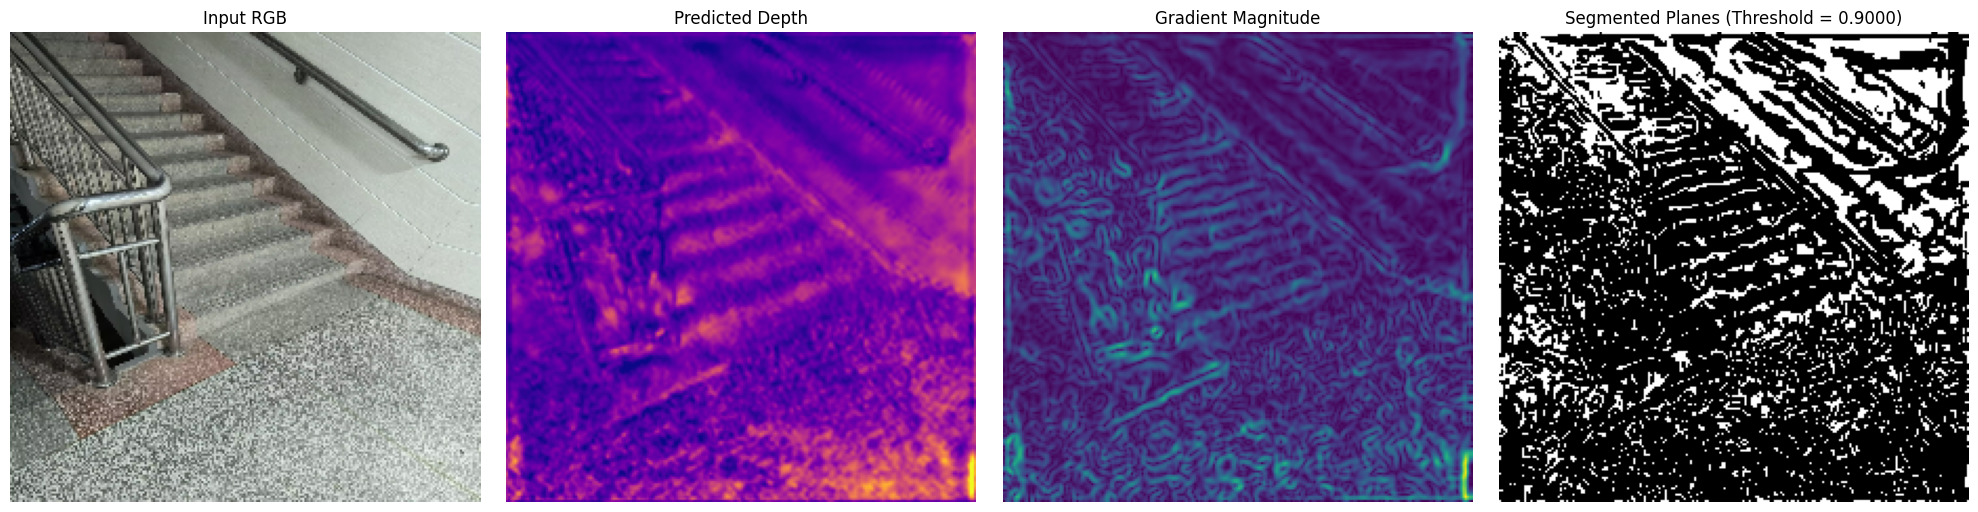

In [50]:
image_path = "/content/drive/MyDrive/DepthProject/dataset/testdata/14.jpg"
raw_img, pred_depth = predict_single_image(model, image_path, device)
visualize_prediction_output(raw_img, pred_depth)


In [ ]:
dir = "/content/drive/MyDrive/DepthProject/dataset/testdata/"
for path in os.listdir(dir):
  if path.endswith(".jpg"):
    image_path = os.path.join(dir, path)
    raw_img, pred_depth = predict_single_image(model, image_path, device)
    visualize_prediction_output(raw_img, pred_depth)


In [ ]:
output_path = ''
cv2.imwrite(output_path, pred_depth)